In [1]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import shutil
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.utils import make_grid
import xml.etree.ElementTree as ET

In [2]:
classes = ['speedlimit', 'trafficlight', 'crosswalk', 'stop']
batch_size = 4
size_per_class = 750

In [5]:
base_data_path = os.path.join(os.getcwd(), 'data')

class CustomDataset(Dataset):
    def __init__(self, data_folder):
        self.data_folder = data_folder
        self.class_labels = ['speedlimit', 'trafficlight', 'crosswalk', 'stop']
        self.images_folder = os.path.join(data_folder, 'images')
        self.annotations_folder = os.path.join(data_folder, 'annotations')
        self.file_list = os.listdir(self.images_folder)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.images_folder, img_name)
        annotation_path = os.path.join(self.annotations_folder, img_name.replace('.png', '.xml'))

        # Read image
        img = Image.open(img_path).convert("RGB")

        # Parse XML file
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Extract class label
        object_elem = root.find('object')
        class_label = object_elem.find('name').text
        class_label = self.class_labels.index(class_label)

        return img, class_label, img_name  # Include image name for copying later

dataset = CustomDataset(data_folder=base_data_path)

# Create subfolders for each class
for label in dataset.class_labels:
    os.makedirs(os.path.join(base_data_path, 'classes_original', label, 'images'), exist_ok=True)
    os.makedirs(os.path.join(base_data_path, 'classes_original', label, 'annotations'), exist_ok=True)

# Iterate through the dataset and copy images and annotations to class-specific folders
for data in dataset:
    img, label, img_name = data
    class_label = dataset.class_labels[label]

    # Copy image
    img_dest_path = os.path.join(base_data_path, 'classes_original', class_label, 'images', img_name)
    shutil.copyfile(os.path.join(base_data_path, 'images', img_name), img_dest_path)

    # Copy annotation
    annotation_dest_path = os.path.join(base_data_path, 'classes_original', class_label, 'annotations', img_name.replace('.png', '.xml'))
    shutil.copyfile(os.path.join(base_data_path, 'annotations', img_name.replace('.png', '.xml')), annotation_dest_path)

In [38]:
import random

start_index = 877
def generate_new_names(old_name, count):
    base_name, extension = os.path.splitext(old_name)
    new_name = f"road{count + start_index}{extension}"
    return new_name

# Create subfolders for augmented data
augmented_folder = os.path.join(base_data_path, 'classes_augmented')
os.makedirs(augmented_folder, exist_ok=True)

for label in dataset.class_labels:
    os.makedirs(os.path.join(augmented_folder, label, 'images'), exist_ok=True)
    os.makedirs(os.path.join(augmented_folder, label, 'annotations'), exist_ok=True)

# Track the count of augmented images per class
augmented_count = {label: 0 for label in dataset.class_labels}
no_images_original = []

# Iterate through classes and copy randomly picked images and annotations to the augmented folder
for class_label in dataset.class_labels:
    current_images_folder = os.path.join(base_data_path, 'classes_original', class_label, 'images')
    current_annotations_folder = os.path.join(base_data_path, 'classes_original', class_label, 'annotations')

    # Calculate max_augmented_images_per_class dynamically
    current_images_count = len(os.listdir(current_images_folder))
    no_images_original.append(current_images_count)
    max_augmented_images_per_class = max(0, size_per_class - current_images_count)

    # Continue picking images until the total count reaches 750
    while augmented_count[class_label] < max_augmented_images_per_class:
        # Randomly pick an image
        random_img_name = random.choice(os.listdir(current_images_folder))
        random_annotation_name = random_img_name.replace('.png', '.xml')

        # Generate new names and paths
        new_img_name = generate_new_names(random_img_name, augmented_count[class_label])
        new_annotation_name = new_img_name.replace('.png', '.xml')

        img_dest_path = os.path.join(augmented_folder, class_label, 'images', new_img_name)
        annotation_dest_path = os.path.join(augmented_folder, class_label, 'annotations', new_annotation_name)

        # Copy and rename image
        shutil.copyfile(os.path.join(current_images_folder, random_img_name), img_dest_path)

        # Copy and rename annotation
        shutil.copyfile(os.path.join(current_annotations_folder, random_annotation_name), annotation_dest_path)

        # Increment count
        augmented_count[class_label] += 1
    
    start_index += augmented_count[class_label]
    print(f"Finished augmenting {class_label} class")

# Print the count of augmented images per class
print("\nAugmented Image Counts:")
for label, count in augmented_count.items():
    print(f"{label}: {count}")

Finished augmenting speedlimit class
Finished augmenting trafficlight class
Finished augmenting crosswalk class
Finished augmenting stop class

Augmented Image Counts:
speedlimit: 98
trafficlight: 689
crosswalk: 662
stop: 674


In [39]:
augmentation_scheme = []
# Define random data augmentation transforms
augmentation1 = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Resize((400, 300))
])
augmentation2 = transforms.Compose([
    transforms.CenterCrop(size=(360, 270)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Resize((400, 300))
])
augmentation3 = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Resize((400, 300))
])
augmentation4 = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.CenterCrop(size=(360, 270)),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), shear=5),
    transforms.ToTensor(),
    transforms.Resize((400, 300))
])
augmentation5 = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Resize((400, 300))
])
augmentation6 = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0., 0.), scale=(0.9, 0.9)),
    transforms.CenterCrop(size=(360, 270)),
    transforms.ToTensor(),
    transforms.Resize((400, 300))
])
augmentation7 = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Resize((400, 300))
])
augmentation8 = transforms.Compose([
    transforms.CenterCrop(size=(360, 270)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Resize((400, 300))
])

augmentation_scheme.append(augmentation1)
augmentation_scheme.append(augmentation2)
augmentation_scheme.append(augmentation3)
augmentation_scheme.append(augmentation4)
augmentation_scheme.append(augmentation5)
augmentation_scheme.append(augmentation6)
augmentation_scheme.append(augmentation7)
augmentation_scheme.append(augmentation8)

def apply_random_augmentation(img, transform):
    return transform(img)

# Iterate through classes and apply random data augmentation
for class_label in dataset.class_labels:
    augmented_images_folder = os.path.join(augmented_folder, class_label, 'images')

    # Track the count of augmented images for the current class
    augmented_count_per_class = 0

    # Create Compose transform with random augmentation
    transform = random.choice(augmentation_scheme)

    # Iterate through images in the class folder
    for img_name in os.listdir(augmented_images_folder):
        img_path = os.path.join(augmented_images_folder, img_name)

        # Read image
        original_img = Image.open(img_path).convert("RGB")

        # Decide whether to apply a new transform every 50 images
        if augmented_count_per_class % 75 == 0:
            transform = random.choice(augmentation_scheme)

        # Apply random data augmentation using transforms.Compose
        augmented_img = apply_random_augmentation(original_img, transform)

        # Save augmented image
        utils.save_image(augmented_img, img_path)

        # Increment count
        augmented_count_per_class += 1

    print("Data augmentation applied successfully for class:", class_label)

Data augmentation applied successfully for class: speedlimit
Data augmentation applied successfully for class: trafficlight
Data augmentation applied successfully for class: crosswalk
Data augmentation applied successfully for class: stop


In [40]:
# move (not copy!) all the images and annotations of the augmented data to the images and annotations folder
for class_label in dataset.class_labels:
    augmented_images_folder = os.path.join(augmented_folder, class_label, 'images')
    augmented_annotations_folder = os.path.join(augmented_folder, class_label, 'annotations')

    for img_name in os.listdir(augmented_images_folder):
        img_path = os.path.join(augmented_images_folder, img_name)
        annotation_path = os.path.join(augmented_annotations_folder, img_name.replace('.png', '.xml'))

        # Move image
        shutil.move(img_path, os.path.join(base_data_path, 'images', img_name))

        # Move annotation
        shutil.move(annotation_path, os.path.join(base_data_path, 'annotations', img_name.replace('.png', '.xml')))

    # Remove class folder
    shutil.rmtree(os.path.join(augmented_folder, class_label))

shutil.rmtree(os.path.join(base_data_path, 'classes_augmented'))

In [54]:
## create dataloader for the dataset
class CustomDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.class_labels = ['speedlimit', 'trafficlight', 'crosswalk', 'stop']
        self.images_folder = os.path.join(data_folder, 'images')
        self.annotations_folder = os.path.join(data_folder, 'annotations')
        self.file_list = os.listdir(self.images_folder)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.images_folder, img_name)
        annotation_path = os.path.join(self.annotations_folder, img_name.replace('.png', '.xml'))

        # Read image
        img = Image.open(img_path).convert("RGB")

        # Apply transform
        if self.transform:
            img = self.transform(img)

        # Parse XML file
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Extract class label
        object_elem = root.find('object')
        class_label = object_elem.find('name').text
        class_label = self.class_labels.index(class_label)

        return img, class_label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
    
dataset = CustomDataset(data_folder=base_data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# test dataloader
for data, labels in dataloader:
    print("Batch shape:", data.shape)
    print("Label shape:", labels.shape)
    print("Label values:", labels)
    break

Dataset size: 3000
Batch shape: torch.Size([4, 3, 400, 300])
Label shape: torch.Size([4])
Label values: tensor([0, 0, 1, 2])


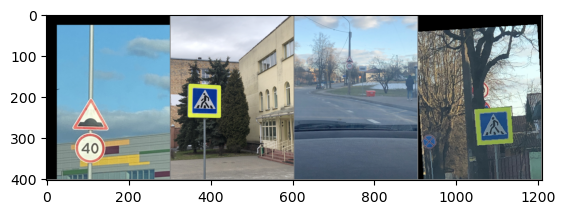

speedlimit	 	crosswalk	 	speedlimit	 	crosswalk


In [57]:
# Visualize a batch of images
def imshow(img):
    img = img / 2 + 0.5 # unnormalize image: [-1, 1] -> [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, axes=(1, 2, 0)))
    # plt.axis('off')
    plt.show()

# get some random training images
images, labels = next(iter(dataloader))

# show images
imshow(make_grid(images))
# print labels
print('\t \t'.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))